# Cat and Dog with simple Convolutional Neural Network<hr/>


In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import random
print(os.listdir())

C:\Users\che99\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['.ipynb_checkpoints', 'catsanddogs', 'inception.png', 'main_CNN.ipynb', 'main_with_google_inception.ipynb', 'normal_inception.png', 'test_set', 'training_set']


## get data and labeling 

cat and dog datas from kaggle 'https://www.kaggle.com/tongpython/cat-and-dog'

we won't remove the color, and all of images will resized 50px X 50px

In [2]:
TRAINING_DIR = './training_set/training_set/'
TEST_DIR = './test_set/test_set/'

In [3]:
def get_data(name):
    x = []
    y = []
    for Dir in os.listdir(name):
        if not Dir.startswith('.'):
            if Dir in ['cats']:
                value = 0
            elif Dir in ['dogs']:
                value = 1
                
            for file in os.listdir(name+'/'+Dir):
                img = cv2.imread(name+'/'+Dir+'/'+file) 
                if img is not None:
                    img = cv2.resize(img,(50, 50))
                    img = np.array(img)
                    x.append(img)
                    y.append(value)
    return np.array(x), np.array(y)

In [4]:
trainx, trainy = get_data(TRAINING_DIR)
testx, testy = get_data(TEST_DIR)

check shape of datas

In [6]:
trainx.shape

(8005, 50, 50, 3)

## Code BatchGenerator
i made it for long time ago, and it's pretty useful ! every time when i do deepleaning

In [7]:
class BatchGenerator():
    where = 0
    
    def __init__(self, x, y, batch_size, one_hot = False, nb_classes = 0):
        self.nb_classes = nb_classes
        self.one_hot = one_hot
        self.x_ = x
        self.y_ = y
        self.batch_size = batch_size
        
        self.total_batch = int(len(x) / batch_size)
        self.x = self.x_[:batch_size,]
        self.y = self.y_[:batch_size,]
        self.where = batch_size
        
        if self.one_hot :
            self.set_one_hot()

    def next_batch(self):
        if self.where + self.batch_size > len(self.x_) :
            left = len(self.x_) - self.where
            self.x = self.x_[len(self.x_) - left:]
            self.y = self.y_[len(self.y_) - left:]
            self.where = 0
            
            if self.one_hot:
                self.set_one_hot()
            
            
        else:
            self.x = self.x_[self.where:self.where+self.batch_size,]
            self.y = self.y_[self.where:self.where+self.batch_size,]
            self.where += self.batch_size
        
            if self.one_hot:
                self.set_one_hot()
        
    def set_one_hot(self):
        one_hot = np.array(self.y).reshape(-1)
        self.y = np.eye(self.nb_classes)[one_hot]
        

## Some of functions to building Neural Network

In [8]:
def create_weight(size, name):
    return tf.Variable(tf.random_normal(size, dtype=tf.float32, stddev=0.01), name = name)
    
def create_bias(size,name):
    return tf.Variable(tf.random_normal(size, dtype=tf.float32, stddev=0.01), name=name)

def conv2d(x,W):
    return tf.nn.conv2d(x,W, strides=[1,1,1,1], padding='SAME')

def max_pooling(x, size, strides):
    return tf.nn.max_pool(x, ksize=size, strides=strides, padding='SAME')

## Set Variables for CNN
3 > 32 > 64 > 128 > 256 > 512 as full connection > 2 (cat or dog)

In [9]:
tf.reset_default_graph()

X = tf.placeholder(shape=[None,50,50,3], dtype=tf.float32)
Y = tf.placeholder(shape=[None,2], dtype=tf.float32)


W1 = create_weight([3,3,3,32],'W1')
b1 = create_bias([32],'b1')

W2 = create_weight([3,3,32,64],'W2')
b2 = create_bias([64],'b2')

W3 = create_weight([3,3,64,128],'W3')
b3 = create_bias([128],'b3')

W4 = create_weight([3,3,128,256],'W4')
b4 = create_bias([256],'b4')

W_out1 = create_weight([50*50*256, 512],'W_out1')
b_out1 = create_bias([512],'b_out1')

W_out2 = create_weight([512,2],'W_out2')
b_out2 = create_bias([2],'b_out2')


## preparing to training
we will use original Gradient Descent Optimizer because it's simple CNN

In [10]:
def model(x, train = True):
    conv2d_1 = max_pooling(tf.nn.relu(conv2d(X, W1) + b1),[1,4,4,1],[1,1,1,1])
    conv2d_2 = max_pooling(tf.nn.relu(conv2d(conv2d_1, W2) + b2),[1,4,4,1],[1,1,1,1])
    conv2d_3 = max_pooling(tf.nn.relu(conv2d(conv2d_2, W3) + b3),[1,4,4,1],[1,1,1,1])
    conv2d_4 = max_pooling(tf.nn.relu(conv2d(conv2d_3, W4) + b4),[1,4,4,1],[1,1,1,1])

    
    FC1 = tf.reshape(conv2d_4, [-1, 50*50*256])
        
    if train:
        FC1 = tf.nn.relu(tf.matmul(FC1, W_out1) + b_out1)
        FC1 = tf.nn.dropout(FC1, keep_prob=0.7)
    
    else:
        FC1 = tf.nn.relu(tf.matmul(FC1, W_out1) + b_out1)
        
    FC2 = tf.matmul(FC1, W_out2) + b_out2
    
    return FC2

In [11]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model(X), labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Let's Training
it will takes 1~ 2 hours , i'm using gpu that 'GTX 1080 TI 11g'

In [12]:
batch = BatchGenerator(trainx, trainy, batch_size=50, nb_classes=2, one_hot=True)
epoches = 1000

print('started!')
for epoch in range(epoches):
    avg_cost = 0
    for i in range(batch.total_batch):
        feed_dict = {X: batch.x, Y: batch.y}
        c, _, = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / batch.total_batch
        batch.next_batch()
        
    print('Epoch:' '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))        

started!
Epoch:0001 cost = 0.153458675
Epoch:0002 cost = 0.354987992
Epoch:0003 cost = 0.421308240
Epoch:0004 cost = 0.435815254
Epoch:0005 cost = 0.386315399
Epoch:0006 cost = 0.404917358
Epoch:0007 cost = 0.394465201
Epoch:0008 cost = 0.378729123
Epoch:0009 cost = 0.363857745
Epoch:0010 cost = 0.413921612
Epoch:0011 cost = 0.421631549
Epoch:0012 cost = 0.428219884
Epoch:0013 cost = 0.491326997
Epoch:0014 cost = 0.545067727
Epoch:0015 cost = 0.538225433
Epoch:0016 cost = 0.513074898
Epoch:0017 cost = 0.475059878
Epoch:0018 cost = 0.445611526
Epoch:0019 cost = 0.396468171
Epoch:0020 cost = 0.383598142
Epoch:0021 cost = 0.385295730
Epoch:0022 cost = 0.386151307
Epoch:0023 cost = 0.356605806
Epoch:0024 cost = 0.338167205
Epoch:0025 cost = 0.337263363
Epoch:0026 cost = 0.337846250
Epoch:0027 cost = 0.325704170
Epoch:0028 cost = 0.314832909
Epoch:0029 cost = 0.329393335
Epoch:0030 cost = 0.319685078
Epoch:0031 cost = 0.312157309
Epoch:0032 cost = 0.314489890
Epoch:0033 cost = 0.303476480
E

Epoch:0274 cost = 0.109303572
Epoch:0275 cost = 0.108452024
Epoch:0276 cost = 0.125135788
Epoch:0277 cost = 0.120045154
Epoch:0278 cost = 0.108643382
Epoch:0279 cost = 0.107447202
Epoch:0280 cost = 0.104366991
Epoch:0281 cost = 0.101463747
Epoch:0282 cost = 0.098672612
Epoch:0283 cost = 0.093687184
Epoch:0284 cost = 0.092228566
Epoch:0285 cost = 0.087826311
Epoch:0286 cost = 0.087457804
Epoch:0287 cost = 0.088023234
Epoch:0288 cost = 0.088080894
Epoch:0289 cost = 0.087137357
Epoch:0290 cost = 0.087405874
Epoch:0291 cost = 0.088898228
Epoch:0292 cost = 0.090285259
Epoch:0293 cost = 0.092765401
Epoch:0294 cost = 0.099488517
Epoch:0295 cost = 0.098664993
Epoch:0296 cost = 0.095391947
Epoch:0297 cost = 0.095225224
Epoch:0298 cost = 0.094564095
Epoch:0299 cost = 0.093151166
Epoch:0300 cost = 0.091899790
Epoch:0301 cost = 0.090318146
Epoch:0302 cost = 0.086660096
Epoch:0303 cost = 0.084424768
Epoch:0304 cost = 0.080894143
Epoch:0305 cost = 0.078557180
Epoch:0306 cost = 0.073668171
Epoch:0307

Epoch:0548 cost = 0.005707297
Epoch:0549 cost = 0.005413794
Epoch:0550 cost = 0.005160016
Epoch:0551 cost = 0.005026382
Epoch:0552 cost = 0.005497145
Epoch:0553 cost = 0.005190557
Epoch:0554 cost = 0.004323003
Epoch:0555 cost = 0.003813853
Epoch:0556 cost = 0.004226695
Epoch:0557 cost = 0.004837618
Epoch:0558 cost = 0.006081291
Epoch:0559 cost = 0.005191603
Epoch:0560 cost = 0.005425136
Epoch:0561 cost = 0.005070143
Epoch:0562 cost = 0.005415427
Epoch:0563 cost = 0.005186324
Epoch:0564 cost = 0.005245187
Epoch:0565 cost = 0.005398274
Epoch:0566 cost = 0.004431511
Epoch:0567 cost = 0.005111260
Epoch:0568 cost = 0.004804143
Epoch:0569 cost = 0.004930179
Epoch:0570 cost = 0.005824145
Epoch:0571 cost = 0.004756501
Epoch:0572 cost = 0.005305883
Epoch:0573 cost = 0.004994441
Epoch:0574 cost = 0.004582365
Epoch:0575 cost = 0.004829004
Epoch:0576 cost = 0.005490729
Epoch:0577 cost = 0.004782509
Epoch:0578 cost = 0.005475555
Epoch:0579 cost = 0.004691785
Epoch:0580 cost = 0.004888214
Epoch:0581

Epoch:0822 cost = 0.004163737
Epoch:0823 cost = 0.003832633
Epoch:0824 cost = 0.003706833
Epoch:0825 cost = 0.004862545
Epoch:0826 cost = 0.004256071
Epoch:0827 cost = 0.004427555
Epoch:0828 cost = 0.003558117
Epoch:0829 cost = 0.003423259
Epoch:0830 cost = 0.004324513
Epoch:0831 cost = 0.004783331
Epoch:0832 cost = 0.003357938
Epoch:0833 cost = 0.005141588
Epoch:0834 cost = 0.003750993
Epoch:0835 cost = 0.003665454
Epoch:0836 cost = 0.003292858
Epoch:0837 cost = 0.004073463
Epoch:0838 cost = 0.004128992
Epoch:0839 cost = 0.004963668
Epoch:0840 cost = 0.004748011
Epoch:0841 cost = 0.004720388
Epoch:0842 cost = 0.003738684
Epoch:0843 cost = 0.003291486
Epoch:0844 cost = 0.004632564
Epoch:0845 cost = 0.004760429
Epoch:0846 cost = 0.004542054
Epoch:0847 cost = 0.004410960
Epoch:0848 cost = 0.003750404
Epoch:0849 cost = 0.006239482
Epoch:0850 cost = 0.005516180
Epoch:0851 cost = 0.004741151
Epoch:0852 cost = 0.004670088
Epoch:0853 cost = 0.003674414
Epoch:0854 cost = 0.004074856
Epoch:0855

## Training Finished!
Let's check , how much accuracy are

In [13]:
correct_prediction = tf.equal(tf.argmax(model(X, False), 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print('----- TRAIN DATA ACCURACY -----')
accu  = 0
batch = BatchGenerator(trainx, trainy, batch_size=30, nb_classes=2,one_hot=True)
for i in range(batch.total_batch):
    feed_dict = {X:batch.x, Y:batch.y}
    accu += sess.run(accuracy, feed_dict=feed_dict)
    batch.next_batch()

print( (accu / batch.total_batch) * 100 , '%' )


print('----- TEST DATA ACCURACY -----')
accu  = 0
test = BatchGenerator(testx, testy, batch_size=100,one_hot=True, nb_classes=2)
for i in range(test.total_batch):
    feed_dict = {X:test.x, Y:test.y}
    accu += sess.run(accuracy, feed_dict=feed_dict)
    test.next_batch()

print( (accu / test.total_batch) * 100 , '%' )

----- TRAIN DATA ACCURACY -----
98.77192956164367 %
----- TEST DATA ACCURACY -----
77.59999960660934 %


## 77 % accuracy! for test datas, you wanna see as image? 

but there is one thing we should do 

OpenCV represents RGB images as multi-dimensional NumPy arrays and  in reverse order

This means that images are actually represented in BGR order rather than RGB!

There’s an easy fix though.

All we need to do is convert the image from BGR to RGB using cv2 before input to plt.plot

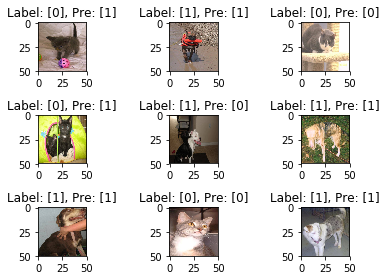

In [101]:
test = BatchGenerator(testx, testy, batch_size=len(testx),one_hot=True, nb_classes=2)

for i in range(9):
    
    r = random.randint(0, len(test.x))
    plt.subplot(3,3,i+1)

    plt.title('Label: {}, Pre: {}'.format(sess.run(tf.argmax(test.y[r:r+1], 1)),
                                                  sess.run(tf.argmax(model(X), 1), 
                                                           feed_dict={X: test.x[r:r+1]})))
    b,g,r = cv2.split(test.x[r])
    plt.imshow( cv2.merge([r,g,b]))
    plt.tight_layout()

## Next time, i will using Google inception for cats and dogs

thanks